# **Assignment 4**

Parsa Youssefpour


In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install pyvirtualdisplay
!sudo apt-get install xvfb

In [ ]:
!sudo apt-get install python-pip
!sudo apt-get install xvfb xserver-xephyr vnc4server
!sudo pip install pyvirtualdisplay

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten
from keras.optimizers import SGD
import keras
import tensorflow as tf
import copy
import math

In [ ]:
env = gym.make("CartPole-v0")
state_size = env.observation_space.shape[0]
actions = env.action_space.n

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns 

## Function to Test the Model's Performance

In [ ]:
def moving_average(data, window_size):
    if window_size <= 0:
        raise ValueError("Window size should be a positive integer")
    if window_size > len(data):
        raise ValueError("Window size should not exceed the length of the data")

    moving_averages = []
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        avg = sum(window) / window_size
        moving_averages.append(avg)

    return moving_averages


#graph the learning curve (reward vs epiosode)
def graph_performance(rewards):
  #taking a moving average to denoise the data
  result = moving_average(rewards,100)
  x = range(len(result))
  y = result

  plt.scatter(x,y, color = "b", marker='.', s=5)
  a, b = np.polyfit(x, y, 1)                        # get the line of bestfit
  plt.plot(x, a*x+b, color = "r")                   # plot the line of besfit
  plt.xlabel("Episodes")
  plt.ylabel("Rewards")
  plt.show()
  print(f"line of best fit equation: {round(a,4)}x + {round(b,4)}")

## Model

In [ ]:
alpha = 0.001
model = Sequential()
model.add(Dense(24,input_shape = (state_size+1,),activation = "relu"))
model.add(Dense(1,activation = "linear"))
model.compile(loss="mse", optimizer=SGD(learning_rate=alpha))

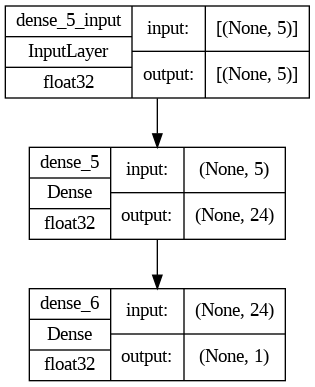

In [ ]:
keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB", #TB: vertical; LR: hor
    expand_nested=True,
    dpi=96,
)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 24)                144       
                                                                 
 dense_6 (Dense)             (None, 1)                 25        
                                                                 
Total params: 169 (676.00 Byte)
Trainable params: 169 (676.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
optimizer=keras.optimizers.SGD(learning_rate=alpha)
f_ppError = keras.losses.MeanSquaredError()

def create_state(obs):
  '''
  Outputs a state per action (2 in total) by adding the action value (0 and 1)
  to the enviroment observation array.
  Modify the shape of the array to match the input of the Nueral Network.
  '''
  obs = [round(element,4) for element in obs]
  action_0 = np.append(obs,0)
  action_1 = np.append(obs,1)
  state_action_0 = tf.reshape(tf.expand_dims(np.asarray(action_0), axis=-1), shape=(1,5))
  state_action_1 = tf.reshape(tf.expand_dims(np.asarray(action_1), axis=-1), shape=(1,5))
  return state_action_0, state_action_1

def select_action(states,epsilon):
  '''
  Recieves the q value for each action state pair.
  Returns the action with the higher value via a epsilon greedy policy.
  '''
  q_a_0 = model(states[0]).numpy()
  q_a_1 = model(states[1]).numpy()
  action = np.random.choice([np.argmax([q_a_0,q_a_1]),np.argmin([q_a_0,q_a_1])], p=[1-epsilon,epsilon])
  return action


#n-SARSA function
def nSarsa_SG(n, gamma, epsilon, epoch):
  '''
  Semi Gradient nSARSA function with Nueral Network (NN)
  Trains the weight of the Nueral Network modle and return the rewards
  and errors per episode.
  Using the 10.2 Algorithm
  '''

  R = []
  errors = []
  for j in range(epoch + 1):
    obs = env.reset()
    states = create_state(obs)
    action = select_action(states,epsilon)

    T = np.inf
    t = 0
    total_rewards = 0
    state_actions = [states[action]]
    rewards = [0]

    # Copying the NN every 100 epsiode to use for bootstrapping
    if j % 100 == 0:
      model_copy = copy.deepcopy(model)

    while True:
      if t<T:
        obs, reward, done, info = env.step(action)
        total_rewards += reward
        states = create_state(obs)
        rewards.append(reward)
        if done:
          T = t+1

        else:
          action = select_action(states,epsilon)
          state_actions.append(states[action])

      tau = t - n + 1

      if tau >= 0:
        G=0
        for i in range(tau+1,min(tau+n+1,T+1)):
          G += gamma**(i-tau-1)*rewards[i]

        if tau+n < T:
          G = G + gamma**n * model_copy(state_actions[tau+n]).numpy()

        #calculating the error and updating the NN weights
        with tf.GradientTape() as tape:
          Q = model(state_actions[tau],training = True)
          ppError = f_ppError(G,Q)
        grads = tape.gradient(ppError,model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))


      if tau == T-1:
        break

      t+=1

    R.append(total_rewards)
    errors.append(ppError)
    if j % 1000 == 0:
        print(f"Episode {j}")
        print("error: ", errors[j].numpy())
        print("reward: ", R[j])

  return R,errors


In [ ]:
results = nSarsa_SG(n=3, gamma=0.99, epsilon = 0.2, epoch=3_000)

Episode 0
error:  0.13798834
reward:  10.0


Episode 1000
error:  116.52105
reward:  21.0


Episode 2000
error:  16.498657
reward:  127.0


Episode 3000
error:  152.08153
reward:  8.0


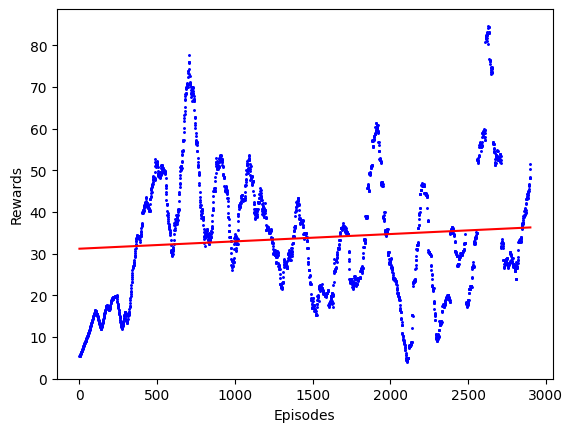

line of best fit equation: 0.0018x + 31.1851


In [ ]:
#Graph of the Errors per Episode
reward, error = results
graph_performance(error)

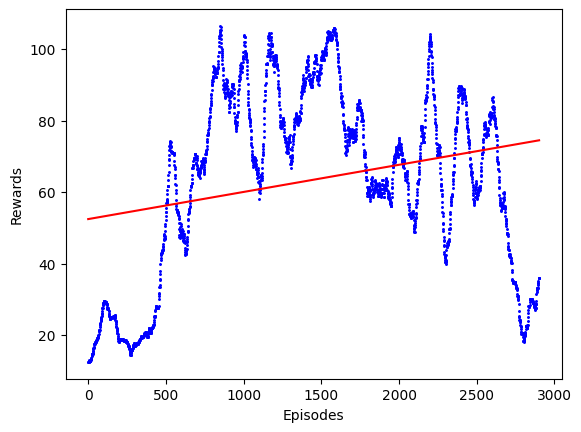

line of best fit equation: 0.0076x + 52.434


In [ ]:
#Graph of the Rewards per Episode
graph_performance(reward)

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

Iterations that were run: 199


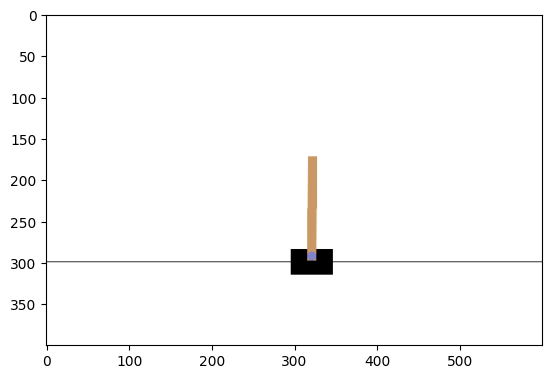

In [ ]:
#TESTING THE TRAINED MODEL
'''
It can be seen that the model was able to successfully achieve a rewards of 200.
'''
env = gym.make("CartPole-v0")
obs = env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)
for i in range(10000):
  states =create_state(obs)
  # action = select_action(states,epsilon=0)
  action = np.argmax([model(states[0]).numpy(),model(states[1]).numpy()])
  print(action)
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()
print("Iterations that were run:",i)